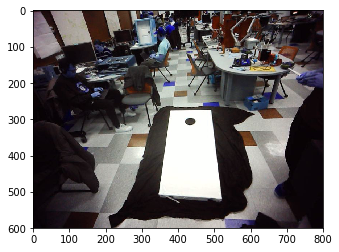

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
%matplotlib inline

# Load original source
img = cv.imread('testpics/t9.png')
orig = img.copy()
plt.imshow(img)

# Utility functions for dealing with contours
def get_cnt_details(cnt):
    M = cv.moments(cnt)
    details = None
    
    if (M['m00'] != 0):
        details = {}
        details['cx'] = cx = int(M['m10']/M['m00'])
        details['cy'] = cy = int(M['m01']/M['m00'])
        details['area'] = area = cv.contourArea(cnt)
        details['perimeter'] = perimeter = cv.arcLength(cnt,True)

    return details

def print_cnt_details(cnt):
    cnt_dict = get_cnt_details(cnt)
    
    if (cnt_dict is None):
        return
    
    cx = cnt_dict['cx']
    cy = cnt_dict['cy']
    area = cnt_dict['area']
    perimeter = cnt_dict['perimeter']

    print('cx: ', cx, '\tcy: ', cy, '\tarea: ', area, '\tperimeter: ', perimeter)

def cnt_is_circular(cnt):
    cnt_det = get_cnt_details(cnt)
    if (cnt_det is None):
        return False
    area = cnt_det['area']
    perimeter = cnt_det['perimeter']
    approx = cv.approxPolyDP(cnt,0.01*cv.arcLength(cnt,True),True)
    return True if (len(approx) > 8 and perimeter < 1000) else False
"""area > 200 and area < 1000 and""" 

def cnt_is_board(cnt):
    cnt_det = get_cnt_details(cnt)
    if (cnt_det is None):
        return False
    area = cnt_det['area']
    approx = cv.approxPolyDP(cnt,0.01*cv.arcLength(cnt,True),True)
    return True if (area > 1000 and area < 30000 and len(approx) < 8) else False

cx:  180 	cy:  540 	area:  4.5 	perimeter:  9.071067690849304
cx:  202 	cy:  526 	area:  0.5 	perimeter:  3.414213538169861
cx:  208 	cy:  518 	area:  9.0 	perimeter:  17.656854152679443
cx:  209 	cy:  510 	area:  4.0 	perimeter:  8.0
cx:  174 	cy:  421 	area:  0.5 	perimeter:  3.414213538169861
cx:  178 	cy:  413 	area:  1.0 	perimeter:  4.828427076339722
cx:  184 	cy:  409 	area:  2.0 	perimeter:  6.0
cx:  171 	cy:  409 	area:  2.0 	perimeter:  8.828427076339722
cx:  201 	cy:  400 	area:  0.5 	perimeter:  3.414213538169861
cx:  190 	cy:  399 	area:  0.5 	perimeter:  3.414213538169861
cx:  201 	cy:  392 	area:  0.5 	perimeter:  3.414213538169861
cx:  163 	cy:  393 	area:  5.5 	perimeter:  12.242640614509583
cx:  189 	cy:  382 	area:  2.0 	perimeter:  6.0
cx:  273 	cy:  286 	area:  62.0 	perimeter:  49.455843687057495
cx:  238 	cy:  416 	area:  22514.0 	perimeter:  1558.6803629398346
cx:  220 	cy:  554 	area:  4.0 	perimeter:  7.656854152679443
cx:  187 	cy:  536 	area:  5.5 	perimeter

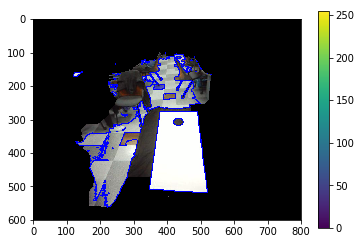

(<matplotlib.image.AxesImage at 0x7fc80a48cc50>,
 None)

In [2]:
ex = img.copy()
mask = np.zeros(img.shape[:2], np.uint8)

bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

#rect = (140,450,260, 500) #y1y2,x1x2
rect = (100,100, 450,500)
cv.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

# threshold binarily
#ret,thresh = cv.threshold(img,127,255,cv.THRESH_BINARY)

# find contours
graysrc = cv.cvtColor(img.copy(), cv.COLOR_BGR2GRAY)
ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1)

# Get board contour and potential hole contours
board_cnt = None
hole_cnts = []
for cnt in contours:
        
    print_cnt_details(cnt)
    if (cnt_is_circular(cnt)):
        hole_cnts.append(cnt)
    if (cnt_is_board(cnt)):
        board_cnt = cnt

# Narrow down potential hole contours so only the ones inside are valid
board_details = get_cnt_details(board_cnt)
if (board_details is not None):
    board_cx = board_details['cx']
    board_cy = board_details['cy']
    
    hole_cnt = None
    for cnt in hole_cnts:
        # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_contours/py_contours_more_functions/py_contours_more_functions.html
        # In the function, third argument is measureDist. If it is True, it finds the signed distance. If False, it finds whether the point is inside or outside or on the contour (it returns +1, -1, 0 respectively).
        loc = cv.pointPolygonTest(cnt, (board_cx,board_cy),False)
        if (loc == 1):
            print("loc=1 TRUE")
            hole_cnt = cnt 
        else:
            continue

src_w_cnts = cv.drawContours(img.copy(), contours, -1, (0,0,255), 2)
plt.imshow(src_w_cnts),plt.colorbar(), plt.show()

In [3]:

if (board_cnt is not None and hole_cnt is not None):
    cv.drawContours(orig, [board_cnt], 0, (0,255,0), cv.FILLED)
    print_cnt_details(board_cnt)
    cv.drawContours(orig, [hole_cnt], 0, (0,0,255), cv.FILLED)
    print_cnt_details(hole_cnt)
    plt.imshow(orig)
else:
    print("board_cnt or hole_cnt null")
    print("board contour: "), print_cnt_details(board_cnt)
    print("hole contour: "), print_cnt_details(hole_cnt)

board_cnt or hole_cnt null
board contour: 
hole contour: 


NameError: name 'hole_cnt' is not defined